## Charger les datasets et les transformer en DF

In [1]:
! pip install google-cloud-storage
! pip install deeplake


[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import os
import json
from matplotlib import pyplot as plt
from google.cloud import storage

In [3]:
def create_dataframe(annotations_path):
    with open(annotations_path, 'r') as file:
        data = json.load(file)

    images = pd.DataFrame(data['images']).rename(columns={'id': 'image_id'})[['image_id', 'file_name', 'width', 'height']]

    categories = pd.DataFrame(data['categories'])[['id', 'name', 'name_readable']]
    categories.rename(columns={'id': 'category_id'}, inplace=True)

    usecols = ['image_id', 'category_id']
    annotations = pd.DataFrame(data['annotations'])[usecols]

    dataframe = annotations.merge(categories, on='category_id').merge(images, on='image_id')[['file_name', 'name', 'name_readable']]

    return dataframe

In [4]:
annotation_train_path = './raw_data/public_training_set_release_2.0/annotations.json'
image_train_path = './raw_data/public_training_set_release_2.0/images'
annotation_val_path = './raw_data/public_validation_set_2.0/annotations.json'
image_val_path = './raw_data/public_validation_set_release_2.0/images'

In [5]:
train_df = create_dataframe(annotation_train_path).drop_duplicates().reset_index(drop=True)
val_df = create_dataframe(annotation_val_path).drop_duplicates().reset_index(drop=True)

## Data Visualisation

#### Nom des 498 catégories

In [6]:
train_df['name_str'] = train_df['name'].apply(lambda x: ''.join(x))
train_df['name_str'].unique()

array(['soft-cheese', 'ham-raw', 'hard-cheese', 'bread-wholemeal',
       'cottage-cheese', 'bread-half-white', 'fruit-salad', 'pancakes',
       'salmon-smoked', 'avocado', 'spring-onion-scallion',
       'ristretto-with-caffeine', 'chips-french-fries', 'pasta',
       'tomato-sauce', 'cheese', 'pear', 'cashew-nut', 'almonds',
       'lentils', 'mixed-vegetables', 'cucumber', 'cocoa-powder',
       'greek-yaourt-yahourt-yogourt-ou-yoghourt',
       'maple-syrup-concentrate', 'buckwheat-grain-peeled', 'chicken',
       'broccoli', 'mayonnaise',
       'green-bean-steamed-without-addition-of-salt', 'sausage',
       'bread-meat-substitute-lettuce-sauce', 'tart', 'rice',
       'tomato-raw', 'white-coffee-with-caffeine', 'apple', 'linseeds',
       'sunflower-seeds', 'ham-cooked', 'lye-pretzel-soft', 'butter',
       'cucumber-pickled', 'soup-cream-of-vegetables', 'banana',
       'pasta-noodles', 'cream', 'cake-chocolate',
       'salad-leaf-salad-green', 'potatoes-steamed', 'white-cabb

#### Nombre d'annotations par images :

In [7]:
train_df = train_df.groupby('file_name')['name'].agg(list).reset_index()
train_df

,file_name,name
0,006316.jpg,[cake-chocolate]
1,006331.jpg,[sugar-melon]
2,006335.jpg,"[mixed-salad-chopped-without-sauce, salad-dres..."
3,006346.jpg,"[chips-french-fries, hamburger, hamburger-bun,..."
4,006351.jpg,[pie-plum-baked-with-cake-dough]
...,...,...
39957,185804.jpg,"[carrot-raw, egg, cheese, bread-white, ham]"
39958,185837.jpg,"[salad-leaf-salad-green, fennel]"
39959,185857.jpg,[grapes]
39960,185859.jpg,[tiramisu]


In [8]:
train_df['nbr_ingredient'] = train_df['name'].agg(len)
train_df_ingr = train_df.sort_values('nbr_ingredient', ascending=True)
train_df_ingr

/tmp/ipykernel_33830/3032456753.py:1: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  train_df['nbr_ingredient'] = train_df['name'].agg(len)


,file_name,name,nbr_ingredient
19717,085898.jpg,[tea-fruit],1
19735,085954.jpg,[ketchup],1
19737,085956.jpg,[wine-red],1
34877,160654.jpg,[tea],1
34879,160667.jpg,[coffee-with-caffeine],1
...,...,...,...
27575,118503.jpg,"[pork, sugar-melon, watermelon-fresh, grapes, ...",11
35496,163431.jpg,"[corn, naan-indien-bread, chickpeas, raspberri...",11
4562,025627.jpg,"[salmon, mushroom, chicken-breast, mustard, ch...",11
9762,045357.jpg,"[watermelon-fresh, apple, lemon, eggplant, fet...",12


(array([2.4302e+04, 7.4500e+03, 4.4570e+03, 2.1350e+03, 9.0500e+02,
        4.2300e+02, 0.0000e+00, 1.7700e+02, 6.8000e+01, 2.4000e+01,
        1.2000e+01, 7.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1.        ,  1.85714286,  2.71428571,  3.57142857,  4.42857143,
         5.28571429,  6.14285714,  7.        ,  7.85714286,  8.71428571,
         9.57142857, 10.42857143, 11.28571429, 12.14285714, 13.        ]),
 <BarContainer object of 14 artists>)

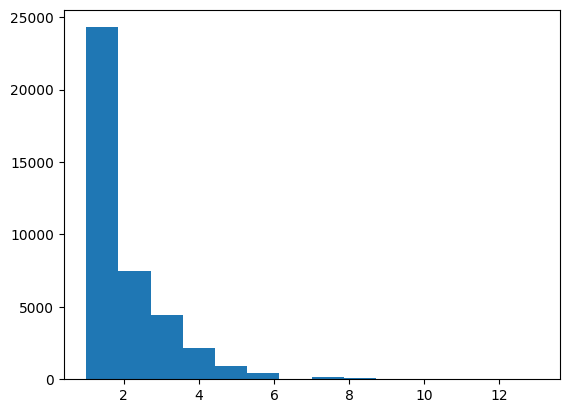

In [9]:
plt.hist(train_df_ingr['nbr_ingredient'], bins=14)

#### On veut garder uniquement les images qui ont 3 annotations ou moins 

Cela permettra d'eviter de trop charger le modèle avec des images trop brouillon 

In [10]:
index_not_valid = train_df_ingr[train_df_ingr['nbr_ingredient'] > 3].index[0]

train_df_filtered = train_df_ingr.copy()

train_df_filtered = train_df_ingr.loc[:index_not_valid]
train_df_filtered

,file_name,name,nbr_ingredient
19717,085898.jpg,[tea-fruit],1
19735,085954.jpg,[ketchup],1
19737,085956.jpg,[wine-red],1
34877,160654.jpg,[tea],1
34879,160667.jpg,[coffee-with-caffeine],1
...,...,...,...
58,006960.jpg,"[egg, avocado, mayonnaise]",3
35,006556.jpg,"[chinese-cabbage, mixed-vegetables, chicken-leg]",3
38,006563.jpg,"[rice, salami, bell-pepper-red-raw]",3
20,006513.jpg,"[thickened-cream-35, berries, meringue]",3


#### Appliquer le mapping au dataframe 

In [11]:
categorie_mapping = {
    'cheese': ['soft-cheese', 'hard-cheese', 'feta', 'blue-mould-cheese', 'cheddar', 'faux-mage-cashew-vegan-chers', 'brie', 'semi-hard-cheese', 'philadelphia', 'cream-cheese', 'fondue',  'parmesan', 'gruyere', 'cheese-for-raclette', 'processed-cheese', 'goat-cheese-soft', 'fresh-cheese', 'cottage-cheese', 'halloumi', 'cheese', 'tomme', 'emmental-cheese', 'mozzarella'],
    'ham': ['ham-raw', 'ham-cooked', 'bacon-frying', 'ham', 'bacon-raw', 'bacon-cooking', 'bacon','ham-turkey'],
    'bread': ['bread-wholemeal', 'bread', 'brioche', 'bread-olive', 'bread-5-grain',  'bagel-without-filling', 'gluten-free-bread', 'kebab-in-pita-bread', 'braided-white-loaf' , 'bread-rye', 'bread-spelt', 'grissini', 'hamburger-bun', 'savoury-puff-pastry-stick','fajita-bread-only', 'bread-wholemeal-toast', 'bread-ticino', 'bread-grain', 'bread-half-white', 'naan-indien-bread', 'bread-french-white-flour',  'bread-sourdough', 'bread-toast', 'bread-whole-wheat', 'bread-white', 'bread-pita'],
    'fish': ['salmond-smoked', 'fish-fingers-breaded', 'shrimp-boiled', 'perch-fillets-lake', 'salmon', 'fish-crunchies-battered', 'fish', 'tuna', 'anchovies', 'tuna-in-oil-drained'],
    'drinks': ['ristretto-with-caffeine','champagne', 'tea-fruit', 'coffee-decaffeinated', 'shoots', 'aperitif-with-alcohol-aperol-spritz', 'tea-ginger', 'tea-verveine', 'light-beer', 'coca-cola', 'sekt', 'coca-cola-zero', 'ice-tea', 'chocolate-milk-chocolate-drink', 'cocktail','coconut-milk' 'wine-rose', 'latte-macchiato-with-caffeine', 'milk', 'syrup-diluted-ready-to-drink', 'tea-peppermint', 'juice-multifruit', 'kefir-drink', 'wine-white', 'tea-spice',  'smoothie', 'soya-drink-soy-milk', 'oat-milk', 'beer', 'tea-rooibos', 'cappuccino', 'tea-black', 'tea', 'prosecco', 'water-mineral', 'juice-orange', 'ice-cubes', 'water', 'water-with-lemon-juice', 'espresso-with-caffeine','white-coffee-with-caffeine', 'tea-green','wine-red', 'juice-apple', 'coffee-with-caffeine', 'herbal-tea'],
    'pasta': ['pasta', 'pasta-noodles', 'lasagne-meat-prepared', 'lasagne-vegetable-prepared', 'pasta-in-conch-form', 'high-protein-pasta-made-of-lentils-peas', 'rice-noodles-vermicelli', 'pasta-in-butterfly-form-farfalle', 'pasta-twist', 'pasta-spaghetti', 'spaetzle', 'pasta-hornli', 'pasta-tortelloni-stuffing', 'pasta-linguini-parpadelle-tagliatelle', 'pasta-penne', 'pasta-ravioli-stuffing',  'pasta-wholemeal'],
    'sauce': ['tomato-sauce', 'mustard-dijon', 'sauce-cocktail', 'tzatziki', 'tartar-sauce', 'sauce-sweet-salted-asian', 'sauce-carbonara', 'sauce-sweet-sour', 'balsamic-vinegar', 'sauce-curry', 'sauce-savoury', 'ketchup', 'sauce-roast', 'bolognaise-sauce', 'sauce-mushroom', 'sauce-pesto', 'curry-vegetarian', 'cream-spinach', 'sauce-cream',  'mayonnaise', 'sauce-soya'],
    'chicken': ['chicken', 'chicken-breast', 'chicken-leg', 'chicken-nuggets', 'chicken-wing', 'chicken-cut-into-stripes-only-meat', 'chicken-curry-cream-coconut-milk-curry-spices-paste'],
    'yoghourt&cream': ['greek-yaourt-yahourt-yogourt-ou-yoghourt', 'cheesecake', 'soya-yaourt-yahourt-yogourt-ou-yoghourt', 'sour-cream', 'yaourt-yahourt-yogourt-ou-yoghourt-natural','cream'],
    'pork': ['sausage', 'veal-sausage', 'smoked-cooked-sausage-of-pork-and-beef-meat-sausag', 'cooked-sausage', 'pork-chop', 'processed-meat-charcuterie','cervelat', 'pork-roast', 'cordon-bleu-from-pork-schnitzel-fried', 'salami', 'wienerli-swiss-sausage', 'pork', 'chorizo', 'pork-escalope', 'frying-sausage'],
    'meat': ['beef-sirloin-steak', 'minced-meat', 'lamb-chop', 'tartar-meat', 'lamb', 'beef-roast', 'meatloaf', 'beef-minced-only-meat', 'dried-meat', 'meat', 'meat-terrine-pate', 'beef', 'beef-filet', 'meat-balls', 'beef-cut-into-stripes-only-meat'],
    'pizza': ['tart', 'pizza-with-ham-with-mushrooms-baked', 'french-pizza-from-alsace-baked', 'pizza-with-ham-baked', 'pizza-with-vegetables-baked', 'quiche-with-cheese-baked-with-puff-pastry', 'pizza-margherita-baked',  'quiche-with-spinach-baked-with-cake-dough'],
    'rice': ['rice', 'rice-basmati', 'cantonese-fried-rice', 'rice-jasmin', 'rice-wild',  'rice-whole-grain', 'rice-waffels', 'risotto-without-cheese-cooked', 'risotto-with-mushrooms-cooked',],
    'seeds': ['buckwheat-grain-peeled', 'bean-seeds','sesame-seeds', 'linseeds', 'seeds', 'sunflower-seeds',  'chia-grains', 'mixed-seeds', 'pumpkin-seeds'],
    'soup': ['soup-cream-of-vegetables', 'soup-tomato', 'soup-vegetable', 'bouillon-vegetable', 'soup-potato', 'soup-pumpkin', 'soup-of-lentils-dahl-dhal', 'bouillon','soup-miso'],
    'cake': ['cake-chocolate','macaroon', 'brownie',  'carrot-cake'],
    'salad': ['salad-leaf-salad-green', 'salad-lambs-ear', 'italian-salad-dressing','greek-salad','oil-vinegar-salad-dressing', 'french-salad-dressing', 'salad-rocket', 'salad-dressing', 'mixed-salad-chopped-without-sauce'],
    'egg': ['egg','omelette-plain', 'eggplant-caviar', 'eggplant', 'egg-scrambled-prepared'],
    'chocolate': ['dark-chocolate', 'chocolate-egg-small', 'chocolate', 'chocolate-mousse', 'white-chocolate', 'chocolate-filled', 'milk-chocolate','milk-chocolate-with-hazelnuts', 'hazelnut-chocolate-spread-nutella-ovomaltine-caotina', 'maple-syrup-concentrate'],
    'pastry': ['croissant', 'waffle', 'croissant-wholegrain' , 'pancakes',  'ham-croissant', 'lye-pretzel-soft', 'pastry-flaky', 'roll-with-pieces-of-chocolate', 'croissant-with-chocolate-filling', 'savoury-puff-pastry'],
    'pie': ['pie-plum-baked-with-cake-dough','pie-rhubarb-baked-with-cake-dough','black-forest-tart', 'pie-apricot-baked-with-cake-dough','lemon-pie', 'apple-pie','fruit-tart'],
    'cake': ['apple-crumble', 'banana-cake', 'cake-marble' ,'tiramisu', 'chocolate-cookies', 'muffin', 'lemon-cake', 'meringue', 'biscuits', 'biscuit-with-butter',],
    'potatoes': ['chips-french-fries', 'butter-spread-puree-almond', 'paprika-chips', 'baked-potato', 'crisps', 'rosti','potatoes-steamed', 'mashed-potatoes-prepared-with-full-fat-milk-with-butter', 'potatoes-au-gratin-dauphinois-prepared', 'potato-salad-with-mayonnaise-yogurt-dressing'],
    'mixed-vegetables': ['mixed-vegetables', 'vegetable-au-gratin-baked', 'vegetables', 'ratatouille', 'vegetable-mix-peas-and-carrots' ],
    'mushrooms': ['mushrooms',  'mushroom-average-stewed-without-addition-of-fat-without-addition-of-salt', 'mushroom' ,'tete-de-moine'],
    'sandwich': ['hamburger', 'sandwich-ham-cheese-and-butter', 'croque-monsieur', 'veggie-burger','hamburger-bread-meat-ketchup' ],
    'nuts': ['cashew-nut', 'almonds', 'peanut','pine-nuts', 'nuts', 'mix-of-dried-fruits-and-nuts', 'chestnuts', 'brazil-nut', 'mixed-nuts', 'hazelnut', 'walnut', 'pistachio', 'pecan-nut', 'praline','crunch-muesli' ]
}

In [12]:
old_category_name = categorie_mapping["pizza"][5]

In [13]:
def map_category(ingredient):
    for new_category, ingredients in categorie_mapping.items():
        if ingredient in ingredients:
            return new_category  # Retourne la clé du mapping
    return ingredient

def process_ingredients(ingredient_list):
    # Si l'entrée est une chaîne, on la transforme en liste
    if isinstance(ingredient_list, str):
        # Nettoyer la chaîne et la transformer en liste
        ingredient_list = ingredient_list.strip('[]').split(', ')
    # Appliquer le mapping sur chaque ingrédient de la liste
    return ', '.join([map_category(ingredient) for ingredient in ingredient_list])

train_df_mapped = train_df_filtered.copy()

train_df_mapped['new_name'] = train_df_filtered['name'].apply(process_ingredients)

train_df_mapped

,file_name,name,nbr_ingredient,new_name
19717,085898.jpg,[tea-fruit],1,drinks
19735,085954.jpg,[ketchup],1,sauce
19737,085956.jpg,[wine-red],1,drinks
34877,160654.jpg,[tea],1,drinks
34879,160667.jpg,[coffee-with-caffeine],1,drinks
...,...,...,...,...
58,006960.jpg,"[egg, avocado, mayonnaise]",3,"egg, avocado, sauce"
35,006556.jpg,"[chinese-cabbage, mixed-vegetables, chicken-leg]",3,"chinese-cabbage, mixed-vegetables, chicken"
38,006563.jpg,"[rice, salami, bell-pepper-red-raw]",3,"rice, pork, bell-pepper-red-raw"
20,006513.jpg,"[thickened-cream-35, berries, meringue]",3,"thickened-cream-35, berries, cake"


On créer un dataframe spécifique pour les boissons qu'on pourra entrainer plus tard au cas ou 

In [14]:
train_df_mapped_without_drinks = train_df_mapped[~train_df_mapped['new_name'].str.contains('drinks', na=False)]
train_df_for_drinks = train_df_mapped[train_df_mapped['new_name'].str.contains('drinks', na=False)]

In [15]:
train_df_mapped_without_drinks.shape

(26731, 4)

In [16]:
train_df_for_drinks

,file_name,name,nbr_ingredient,new_name
19717,085898.jpg,[tea-fruit],1,drinks
19737,085956.jpg,[wine-red],1,drinks
34877,160654.jpg,[tea],1,drinks
34879,160667.jpg,[coffee-with-caffeine],1,drinks
34854,160539.jpg,[coffee-with-caffeine],1,drinks
...,...,...,...,...
3906,022399.jpg,"[biscuits, coffee-with-caffeine, dark-chocolate]",3,"cake, drinks, chocolate"
13924,068148.jpg,"[wine-red, bread-rye, cheese]",3,"drinks, bread, cheese"
14168,069037.jpg,"[bread-white, tea, margarine]",3,"bread, drinks, margarine"
3954,022654.jpg,"[biscuits, coffee-with-caffeine, dark-chocolate]",3,"cake, drinks, chocolate"


## Nouvelle représentation des catégories

In [17]:
train_df_mapped_viz = train_df_mapped.groupby('new_name')['new_name'].apply('count')
train_df_mapped_viz = pd.DataFrame(train_df_mapped_viz.sort_values(ascending=False))
train_df_mapped_viz = train_df_mapped_viz[train_df_mapped_viz['new_name'] > 100]
train_df_mapped_viz

,new_name
new_name,
drinks,8726
bread,2140
nuts,760
apple,651
cheese,608
salad,604
pastry,454
"bread, butter",452
chocolate,444


#### Préparation du JSON 

In [18]:
annotation_train_path = './raw_data/public_training_set_release_2.0/annotations.json'
annotation_val_path = './raw_data/public_validation_set_2.0/annotations.json'

new_annotation_train = './raw_data/public_training_set_release_2.0/new_annotations.json'
new_annotation_val = './raw_data/public_validation_set_2.0/new_annotations.json'

In [19]:
categorie_mapping = {
    'cheese': ['soft-cheese', 'hard-cheese', 'feta', 'blue-mould-cheese', 'cheddar', 'faux-mage-cashew-vegan-chers', 'brie', 'semi-hard-cheese', 'philadelphia', 'cream-cheese', 'fondue',  'parmesan', 'gruyere', 'cheese-for-raclette', 'processed-cheese', 'goat-cheese-soft', 'fresh-cheese', 'cottage-cheese', 'halloumi', 'cheese', 'tomme', 'emmental-cheese', 'mozzarella'],
    'ham': ['ham-raw', 'ham-cooked', 'bacon-frying', 'ham', 'bacon-raw', 'bacon-cooking', 'bacon','ham-turkey'],
    'bread': ['bread-wholemeal', 'bread', 'brioche', 'bread-olive', 'bread-5-grain',  'bagel-without-filling', 'gluten-free-bread', 'kebab-in-pita-bread', 'braided-white-loaf' , 'bread-rye', 'bread-spelt', 'grissini', 'hamburger-bun', 'savoury-puff-pastry-stick','fajita-bread-only', 'bread-wholemeal-toast', 'bread-ticino', 'bread-grain', 'bread-half-white', 'naan-indien-bread', 'bread-french-white-flour',  'bread-sourdough', 'bread-toast', 'bread-whole-wheat', 'bread-white', 'bread-pita'],
    'fish': ['salmond-smoked', 'salmon-smoked', 'fish-fingers-breaded', 'shrimp-boiled', 'perch-fillets-lake', 'salmon', 'fish-crunchies-battered', 'fish', 'tuna', 'anchovies', 'tuna-in-oil-drained'],
    'drinks': ['ristretto-with-caffeine','champagne', 'tea-fruit', 'coffee-decaffeinated', 'shoots', 'aperitif-with-alcohol-aperol-spritz', 'tea-ginger', 'tea-verveine', 'light-beer', 'coca-cola', 'sekt', 'coca-cola-zero', 'ice-tea', 'chocolate-milk-chocolate-drink', 'cocktail','coconut-milk' 'wine-rose', 'latte-macchiato-with-caffeine', 'milk', 'syrup-diluted-ready-to-drink', 'tea-peppermint', 'juice-multifruit', 'kefir-drink', 'wine-white', 'tea-spice',  'smoothie', 'soya-drink-soy-milk', 'oat-milk', 'beer', 'tea-rooibos', 'cappuccino', 'tea-black', 'tea', 'prosecco', 'water-mineral', 'juice-orange', 'ice-cubes', 'water', 'water-with-lemon-juice', 'espresso-with-caffeine','white-coffee-with-caffeine', 'tea-green','wine-red', 'juice-apple', 'coffee-with-caffeine', 'herbal-tea'],
    'pasta': ['pasta', 'pasta-noodles', 'lasagne-meat-prepared', 'lasagne-vegetable-prepared', 'pasta-in-conch-form', 'high-protein-pasta-made-of-lentils-peas', 'rice-noodles-vermicelli', 'pasta-in-butterfly-form-farfalle', 'pasta-twist', 'pasta-spaghetti', 'spaetzle', 'pasta-hornli', 'pasta-tortelloni-stuffing', 'pasta-linguini-parpadelle-tagliatelle', 'pasta-penne', 'pasta-ravioli-stuffing',  'pasta-wholemeal'],
    'sauce': ['tomato-sauce', 'mustard-dijon', 'sauce-cocktail', 'tzatziki', 'tartar-sauce', 'sauce-sweet-salted-asian', 'sauce-carbonara', 'sauce-sweet-sour', 'balsamic-vinegar', 'sauce-curry', 'sauce-savoury', 'ketchup', 'sauce-roast', 'bolognaise-sauce', 'sauce-mushroom', 'sauce-pesto', 'curry-vegetarian', 'cream-spinach', 'sauce-cream',  'mayonnaise', 'sauce-soya'],
    'chicken': ['chicken', 'chicken-breast', 'chicken-leg', 'chicken-nuggets', 'chicken-wing', 'chicken-cut-into-stripes-only-meat', 'chicken-curry-cream-coconut-milk-curry-spices-paste'],
    'yoghourt&cream': ['greek-yaourt-yahourt-yogourt-ou-yoghourt', 'cheesecake', 'soya-yaourt-yahourt-yogourt-ou-yoghourt', 'sour-cream', 'yaourt-yahourt-yogourt-ou-yoghourt-natural','cream'],
    'pork': ['sausage', 'veal-sausage', 'smoked-cooked-sausage-of-pork-and-beef-meat-sausag', 'cooked-sausage', 'pork-chop', 'processed-meat-charcuterie','cervelat', 'pork-roast', 'cordon-bleu-from-pork-schnitzel-fried', 'salami', 'wienerli-swiss-sausage', 'pork', 'chorizo', 'pork-escalope', 'frying-sausage'],
    'meat': ['beef-sirloin-steak', 'minced-meat', 'lamb-chop', 'tartar-meat', 'lamb', 'beef-roast', 'meatloaf', 'beef-minced-only-meat', 'dried-meat', 'meat', 'meat-terrine-pate', 'beef', 'beef-filet', 'meat-balls', 'beef-cut-into-stripes-only-meat'],
    'pizza': ['tart', 'pizza-with-ham-with-mushrooms-baked', 'french-pizza-from-alsace-baked', 'pizza-with-ham-baked', 'pizza-with-vegetables-baked', 'quiche-with-cheese-baked-with-puff-pastry', 'pizza-margherita-baked',  'quiche-with-spinach-baked-with-cake-dough'],
    'rice': ['rice', 'rice-basmati', 'cantonese-fried-rice', 'rice-jasmin', 'rice-wild',  'rice-whole-grain', 'rice-waffels', 'risotto-without-cheese-cooked', 'risotto-with-mushrooms-cooked',],
    'seeds': ['buckwheat-grain-peeled', 'bean-seeds','sesame-seeds', 'linseeds', 'seeds', 'sunflower-seeds',  'chia-grains', 'mixed-seeds', 'pumpkin-seeds'],
    'soup': ['soup-cream-of-vegetables', 'soup-tomato', 'soup-vegetable', 'bouillon-vegetable', 'soup-potato', 'soup-pumpkin', 'soup-of-lentils-dahl-dhal', 'bouillon','soup-miso'],
    'cake': ['cake-chocolate', 'macaroon', 'brownie',  'carrot-cake'],
    'salad': ['salad-leaf-salad-green', 'salad-lambs-ear', 'italian-salad-dressing','greek-salad','oil-vinegar-salad-dressing', 'french-salad-dressing', 'salad-rocket', 'salad-dressing', 'mixed-salad-chopped-without-sauce'],
    'egg': ['egg','omelette-plain', 'eggplant-caviar', 'eggplant', 'egg-scrambled-prepared'],
    'chocolate': ['dark-chocolate', 'chocolate-egg-small', 'chocolate', 'chocolate-mousse', 'white-chocolate', 'chocolate-filled', 'milk-chocolate','milk-chocolate-with-hazelnuts', 'hazelnut-chocolate-spread-nutella-ovomaltine-caotina', 'maple-syrup-concentrate'],
    'pastry': ['croissant', 'waffle', 'croissant-wholegrain' , 'pancakes',  'ham-croissant', 'lye-pretzel-soft', 'pastry-flaky', 'roll-with-pieces-of-chocolate', 'croissant-with-chocolate-filling', 'savoury-puff-pastry'],
    'pie': ['pie-plum-baked-with-cake-dough','pie-rhubarb-baked-with-cake-dough','black-forest-tart', 'pie-apricot-baked-with-cake-dough','lemon-pie', 'apple-pie','fruit-tart'],
    'cake': ['apple-crumble', 'banana-cake', 'cake-marble' ,'tiramisu', 'chocolate-cookies', 'muffin', 'lemon-cake', 'meringue', 'biscuits', 'biscuit-with-butter',],
    'potatoes': ['chips-french-fries', 'butter-spread-puree-almond', 'paprika-chips', 'sweet-potato', 'baked-potato', 'crisps', 'rosti','potatoes-steamed', 'mashed-potatoes-prepared-with-full-fat-milk-with-butter', 'potatoes-au-gratin-dauphinois-prepared', 'potato-salad-with-mayonnaise-yogurt-dressing'],
    'mixed-vegetables': ['mixed-vegetables', 'vegetable-au-gratin-baked', 'vegetables', 'ratatouille', 'vegetable-mix-peas-and-carrots' ],
    'mushrooms': ['mushrooms',  'mushroom-average-stewed-without-addition-of-fat-without-addition-of-salt', 'mushroom' ,'tete-de-moine'],
    'sandwich': ['hamburger', 'sandwich-ham-cheese-and-butter', 'croque-monsieur', 'veggie-burger','hamburger-bread-meat-ketchup' ],
    'nuts': ['cashew-nut', 'almonds', 'peanut','pine-nuts', 'nuts', 'mix-of-dried-fruits-and-nuts', 'chestnuts', 'brazil-nut', 'mixed-nuts', 'hazelnut', 'walnut', 'pistachio', 'pecan-nut', 'praline','crunch-muesli' ]
}


In [20]:
with open(annotation_val_path, 'r') as file:
    data = json.load(file)

category_id_map = {category["name"]: category["id"] for category in data['categories']}

supercategory_id = {key: idx+1 for idx, key in enumerate(categorie_mapping.keys())}

category_correspondence = {}

category_correspondence = {}

# Parcourir chaque catégorie existante
for category_name, category_id in category_id_map.items():
    # Vérifier si la catégorie est présente dans le mapping
    found = False
    for supercat, old_categories in categorie_mapping.items():
        if category_name in old_categories:
            # Associer à l'ID de la supercatégorie
            supercat_id = supercategory_id[supercat]
            category_correspondence[category_name] = [category_id, supercat_id]
            found = True
            break
    # Si la catégorie n'est pas dans le mapping, elle conserve son ancien ID
    if not found:
        category_correspondence[category_name] = [category_id, category_id]

len(category_correspondence)

498

In [21]:
for annotation in data['annotations']:
    current_id = annotation["category_id"]
    for category_name, ids in category_correspondence.items():
        if current_id == ids[0]:
            annotation["category_id"] = ids[1]
            break

new_categories = []
for supercat, supercat_id in supercategory_id.items():
    new_categories.append({
        "id": supercat_id,
        "name": supercat,
        "name_readable": supercat.capitalize(),
        "supercategory": "food"
    })

cleaned_categories = []

for category in data['categories']:
    category_name = category["name"]
    category_id = category["id"]

    if category_name in category_correspondence:
        old_id, new_id = category_correspondence[category_name]
        if old_id == new_id:
            cleaned_categories.append(category)
    else:

        cleaned_categories.append(category)


cleaned_categories.extend(new_categories)

data['categories'] = cleaned_categories

with open(new_annotation_val, 'w') as file:
    json.dump(data, file, indent=4)

In [22]:
with open(annotation_train_path, 'r') as file:
    data = json.load(file)

category_id_map = {category["name"]: category["id"] for category in data['categories']}

supercategory_id = {key: idx+1 for idx, key in enumerate(categorie_mapping.keys())}

category_correspondence = {}

category_correspondence = {}

# Parcourir chaque catégorie existante
for category_name, category_id in category_id_map.items():
    # Vérifier si la catégorie est présente dans le mapping
    found = False
    for supercat, old_categories in categorie_mapping.items():
        if category_name in old_categories:
            # Associer à l'ID de la supercatégorie
            supercat_id = supercategory_id[supercat]
            category_correspondence[category_name] = [category_id, supercat_id]
            found = True
            break
    # Si la catégorie n'est pas dans le mapping, elle conserve son ancien ID
    if not found:
        category_correspondence[category_name] = [category_id, category_id]

len(category_correspondence)

498

In [23]:
for annotation in data['annotations']:
    current_id = annotation["category_id"]
    for category_name, ids in category_correspondence.items():
        if current_id == ids[0]:
            annotation["category_id"] = ids[1]
            break

new_categories = []
for supercat, supercat_id in supercategory_id.items():
    new_categories.append({
        "id": supercat_id,
        "name": supercat,
        "name_readable": supercat.capitalize(),
        "supercategory": "food"
    })

cleaned_categories = []

for category in data['categories']:
    category_name = category["name"]
    category_id = category["id"]

    if category_name in category_correspondence:
        old_id, new_id = category_correspondence[category_name]
        if old_id == new_id:
            cleaned_categories.append(category)
    else:

        cleaned_categories.append(category)


cleaned_categories.extend(new_categories)

data['categories'] = cleaned_categories

with open(new_annotation_train, 'w') as file:
    json.dump(data, file, indent=4)

In [24]:
supercategory_id


{'cheese': 1,
 'ham': 2,
 'bread': 3,
 'fish': 4,
 'drinks': 5,
 'pasta': 6,
 'sauce': 7,
 'chicken': 8,
 'yoghourt&cream': 9,
 'pork': 10,
 'meat': 11,
 'pizza': 12,
 'rice': 13,
 'seeds': 14,
 'soup': 15,
 'cake': 16,
 'salad': 17,
 'egg': 18,
 'chocolate': 19,
 'pastry': 20,
 'pie': 21,
 'potatoes': 22,
 'mixed-vegetables': 23,
 'mushrooms': 24,
 'sandwich': 25,
 'nuts': 26}

In [45]:
with open(new_annotation_val, 'r') as file:
    data = json.load(file)

data["categories"] = [category for category in data["categories"] if category["id"] != 5]
data["categories"] = [category for category in data["categories"] if category["id"] != 3]

# Étape 2 : Filtrer les annotations pour retirer celles avec category_id = 5

filtered_annotations = [annotation for annotation in data["annotations"] if annotation["category_id"] != 3]
filtered_annotationss = [annotation for annotation in filtered_annotations if annotation["category_id"] != 5]

# Étape 3 : Identifier les images à conserver (qui ont encore des annotations)
valid_image_ids = {annotation["image_id"] for annotation in filtered_annotationss}

# Étape 4 : Filtrer les images pour ne conserver que celles qui ont des annotations valides
data["images"] = [image for image in data["images"] if image["id"] in valid_image_ids]

# Étape 5 : Mettre à jour le champ annotations avec les annotations filtrées
data["annotations"] = filtered_annotationss

with open('./raw_data/public_validation_set_2.0/updated_annotations_drinks.json', 'w') as file:
    json.dump(data, file, indent=4)

In [47]:
print(len([anno for anno in data['annotations'] if anno['category_id']==5]))

0


In [48]:
with open(new_annotation_train, 'r') as file:
    data = json.load(file)

data["categories"] = [category for category in data["categories"] if category["id"] != 5]
data["categories"] = [category for category in data["categories"] if category["id"] != 3]

# Étape 2 : Filtrer les annotations pour retirer celles avec category_id = 5

filtered_annotations = [annotation for annotation in data["annotations"] if annotation["category_id"] != 3]
filtered_annotationss = [annotation for annotation in filtered_annotations if annotation["category_id"] != 5]

# Étape 3 : Identifier les images à conserver (qui ont encore des annotations)
valid_image_ids = {annotation["image_id"] for annotation in filtered_annotationss}

# Étape 4 : Filtrer les images pour ne conserver que celles qui ont des annotations valides
data["images"] = [image for image in data["images"] if image["id"] in valid_image_ids]

# Étape 5 : Mettre à jour le champ annotations avec les annotations filtrées
data["annotations"] = filtered_annotationss

with open('./raw_data/public_training_set_release_2.0/updated_annotations_drinks.json', 'w') as file:
    json.dump(data, file, indent=4)

In [35]:
print(len([anno for anno in filtered_annotations if anno['category_id']==5]))

13898
